In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import shapefile
from shapely.geometry import mapping, Polygon 
import time
import wget
import rioxarray as rio
import xarray as xr
import numpy as np
import datetime as dt

In [2]:
class Reader:
    def __init__(self):
        self.shapefile = None
        self.indexes = None
        self.df_features = None
        self.projections = None
        self.NORTHWEST_KNOWLEDGE = "http://www.northwestknowledge.net/metdata/data/"


    def read_shapefile(self, shapefile="./vector_input/mtbs_fod_pts_data/mtbs_FODpoints_DD.shp",
                       indexes=None,
                       db_features=None):
        
        self.shapefile = gpd.read_file(shapefile)
        if(indexes != None):
            self.indexes = gpd.read_file(indexes)
        if(db_features != None):
            self.db_features = pd.DataFrame(gpd.read_file(db_features))

    def output_shapefile(self, print_head=False, print_columns=False, print_extra_variables=False, close_window_after_sleep=True, plot_file=True):
        if(print_head):
            print(self.shapefile.head())
        if(print_columns):
            print(self.shapefile.columns)
        if(print_extra_variables):
            print(self.indexes.head())
            print(self.indexes.columns)
            print(self.db_features.head())
            print(self.db_features.columns)
        #print(self.projections)
        self.shapefile.plot()
        if(plot_file):
            plt.show()
            if (close_window_after_sleep):
                time.sleep(5)
                plt.close()

    def inspect_polygons(self):
        for row in self.shapefile['geometry']:
            print(row)
            """
            has list of polygons and multipolygons
            """

    def plot_polygon(self, polygons_to_plot=1):
        for index, row in self.shapefile.iterrows():
            #for col in self.shapefile.columns:
            #print(col + ": " + str(self.shapefile.iloc[index][col]) + "\n")
            print("about to plot")
            poly = gpd.GeoSeries(row.geometry)
            print(poly)
            poly.plot()
            print("plotted")
            plt.show()
            time.sleep(5)
            plt.close()
            
    def retrieve_state(self, state):
        poly = self.shapefile.loc[self.shapefile['NAME'].str.lower() == state.lower(), "geometry"]
        return poly
    
    def plot_state(self, polygon):
        polygon.plot()
        plt.show()
        
    def read_netcdf_from_web(self, variable, year, source=None):
        if source == None:
            source  = self.NORTHWEST_KNOWLEDGE
        url = source+str(variable)+"_"+str(year)+".nc"
        file = wget.download(url)
        return file
    
    def load_file_into_xarray(self, variable, year, use_downloaded_file=True):
        
        if(use_downloaded_file):
            filename = "input/" + variable.lower() + "_" + str(year) + ".nc"
            file_xarray = xr.open_dataset(filename)
        else:
            filename = self.read_netcdf_from_web(variable, year)
            file_xarray = xr.open_dataset(filename)
        return file_xarray
    
    def find_nearest(self, array, value, return_index = True):
        #needes modification, determine if index closer is upper left or lower right
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin() - 1 # - 1 is to go to the preceding index, assuming coordinate found is lower right and pixel coordinate is upper left
        idx = 0 if idx < 0 else idx
        if return_index:
            return idx
        return array[idx]

In [5]:
reader = Reader()
# sph (Near-Surface Specific Humidity)
# vpd (Mean Vapor Pressure Deficit)
# pr (Precipitation)
# rmin (Minimum Near-Surface Relative Humidity)
# rmax (Maximum Near-Surface Relative Humidity)
# srad (Surface Downwelling Solar Radiation)
# tmmn (Minimum Near-Surface Air Temperature)
# tmmx (Maximum Near-Surface Air Temperature)
# vs (Wind speed at 10 m)
# th (Wind direction at 10 m)
# pdsi (Palmer Drought Severity Index)
# pet (Reference grass evaportranspiration)
# etr (Reference alfalfa evaportranspiration)
# ERC (model-G)
# BI (model-G)
# FM100 (100-hour dead fuel moisture)
# FM1000 (1000-hour dead fuel moisture)

In [14]:
sph_file = reader.read_netcdf_from_web("sph", 2020)
sph_xr = rio.open_rasterio(sph_file)

100% [......................................................................] 187171109 / 187171109

In [15]:
pr_file = reader.read_netcdf_from_web("pr", 2020)
pr_xr = rio.open_rasterio(pr_file)

100% [........................................................................] 58709474 / 58709474

In [16]:
reader.read_shapefile("./vector_input/US_States/cb_2018_us_state_500k/cb_2018_us_state_500k.shp", None, None)

In [17]:
montana_poly = reader.retrieve_state("Montana")

In [18]:
sph_xr

<xarray.DataArray 'specific_humidity' (day: 366, y: 585, x: 1386)>
[296756460 values with dtype=uint16]
Coordinates:
  * day      (day) object 2020-01-01 00:00:00 ... 2020-12-31 00:00:00
  * x        (x) float64 -124.8 -124.7 -124.7 -124.6 ... -67.14 -67.1 -67.06
  * y        (y) float64 49.4 49.36 49.32 49.28 ... 25.19 25.15 25.11 25.07
    crs      int32 0
Attributes:
    add_offset:         0.0
    coordinates:        lon lat
    coordinate_system:  WGS84,EPSG:4326
    description:        Daily mean specific humidity (2m)
    dimensions:         lon lat time
    long_name:          sph
    missing_value:      32767
    scale_factor:       1e-05
    standard_name:      sph
    units:              ('kg/kg', 'kg/kg', 'kg/kg', 'kg/kg', 'kg/kg', 'kg/kg'...
    _FillValue:         32767.0
    _Unsigned:          true

In [19]:
type(sph_xr)

xarray.core.dataarray.DataArray

In [21]:
date = "2020/01/31" # "yyyy/mm/dd"
day = (dt.date(int(date[0:4]), int(date[5:7]), int(date[8:])) - dt.date(int(date[0:4]), 1, 1)).days


In [22]:
sph_clipped = sph_xr.rio.write_crs(montana_poly.crs).rio.clip(montana_poly.geometry.apply(mapping))

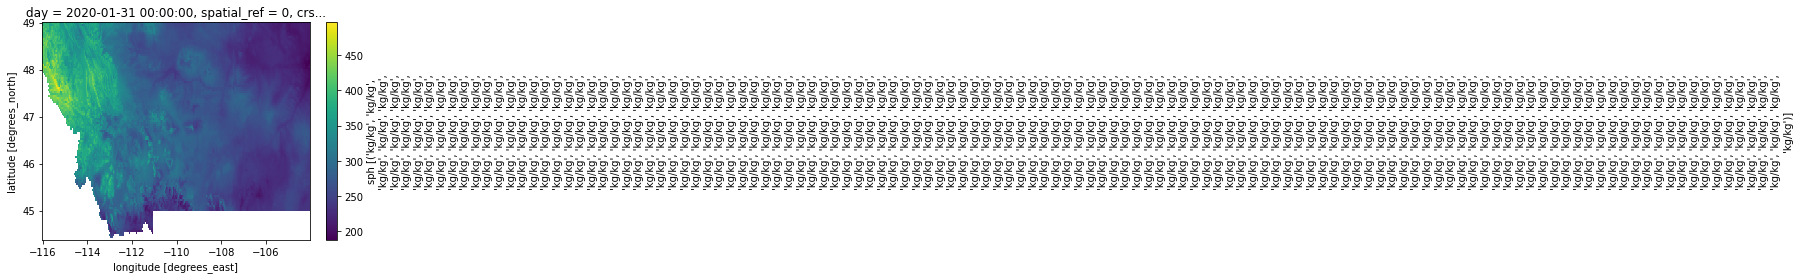

In [25]:
sph_clipped = sph_clipped.where(sph_clipped != sph_clipped.attrs['_FillValue'])
sph_clipped[day,:,:].plot()

In [57]:
test_y = 48.87
test_x = -115.91
found_x = reader.find_nearest(sph_clipped[day,:,:].x, test_x)
print(found_x)

2


In [58]:
found_y = reader.find_nearest(sph_clipped[day,:,:].y, test_y)
print(found_y)

2


In [59]:
pixel = sph_clipped[day,found_y, found_x]

In [60]:
pixel

<xarray.DataArray 'specific_humidity' ()>
array(397.)
Coordinates:
    y            float64 48.9
    x            float64 -115.9
    day          object 2020-01-31 00:00:00
    spatial_ref  int32 0
    crs          int32 0
Attributes:
    add_offset:         0.0
    coordinates:        lon lat
    coordinate_system:  WGS84,EPSG:4326
    description:        Daily mean specific humidity (2m)
    dimensions:         lon lat time
    long_name:          sph
    scale_factor:       1e-05
    standard_name:      sph
    units:              ('kg/kg', 'kg/kg', 'kg/kg', 'kg/kg', 'kg/kg', 'kg/kg'...
    _Unsigned:          true
    _FillValue:         32767

In [105]:
example_df_dict = {"day" : [day], "day_as_date" : [date], "longitude" : [test_x], "latitude" : [test_y], "sph" : [np.NaN], "pr" : [np.NaN], "th" : [np.NaN], "vs" : [np.NaN]}
example_df = pd.DataFrame.from_dict(example_df_dict)

In [106]:
example_df

,day,day_as_date,longitude,latitude,sph,pr,th,vs
0,30,2020/01/31,-115.91,48.87,NaN,NaN,NaN,NaN


In [107]:
#set value
example_df['sph'] = np.where((example_df.latitude == test_y) & (example_df.longitude == test_x),pixel,example_df.sph)

In [108]:
example_df

,day,day_as_date,longitude,latitude,sph,pr,th,vs
0,30,2020/01/31,-115.91,48.87,397.0,NaN,NaN,NaN


In [109]:
pr_clipped = pr_xr.rio.write_crs(montana_poly.crs).rio.clip(montana_poly.geometry.apply(mapping))

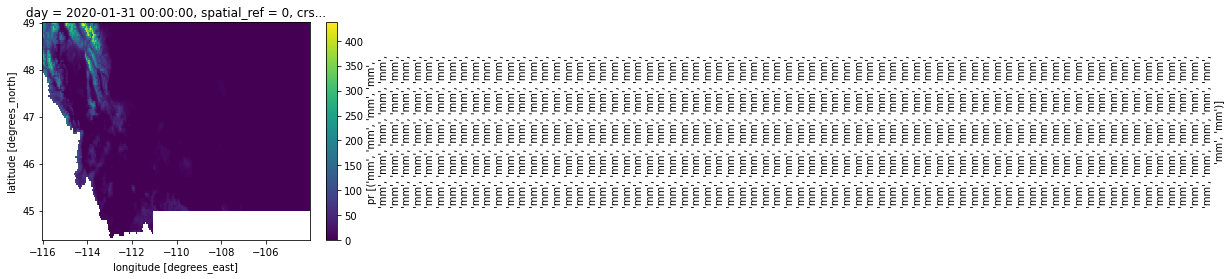

In [110]:
pr_clipped = pr_clipped.where(pr_clipped != pr_clipped.attrs['_FillValue'])
pr_clipped[day,:,:].plot()

In [111]:
found_x = reader.find_nearest(pr_clipped[day,:,:].x, test_x)
print(found_x)
found_y = reader.find_nearest(pr_clipped[day,:,:].y, test_y)
print(found_y)

2
2


In [112]:
pr_pixel = pr_clipped[day,found_y, found_x]
print(pr_pixel)

<xarray.DataArray 'precipitation_amount' ()>
array(185.)
Coordinates:
    y            float64 48.9
    x            float64 -115.9
    day          object 2020-01-31 00:00:00
    spatial_ref  int32 0
    crs          int32 0
Attributes:
    add_offset:         0.0
    coordinates:        lon lat
    coordinate_system:  WGS84,EPSG:4326
    description:        Daily Accumulated Precipitation
    dimensions:         lon lat time
    long_name:          pr
    scale_factor:       0.1
    standard_name:      pr
    units:              ('mm', 'mm', 'mm', 'mm', 'mm', 'mm', 'mm', 'mm', 'mm'...
    _Unsigned:          true
    _FillValue:         32767


In [113]:
example_df['pr'] = np.where((example_df.latitude == test_y) & (example_df.longitude == test_x),pr_pixel,example_df.pr)

In [114]:
example_df

,day,day_as_date,longitude,latitude,sph,pr,th,vs
0,30,2020/01/31,-115.91,48.87,397.0,185.0,NaN,NaN


In [98]:
th_file = reader.read_netcdf_from_web("th", 2020)
th_xr = rio.open_rasterio(th_file)

100% [........................................................................] 28101810 / 28101810

In [99]:
vs_file = reader.read_netcdf_from_web("vs", 2020)
vs_xr = rio.open_rasterio(vs_file)

100% [........................................................................] 61410946 / 61410946

In [100]:
th_clipped = th_xr.rio.write_crs(montana_poly.crs).rio.clip(montana_poly.geometry.apply(mapping))

In [101]:
vs_clipped = vs_xr.rio.write_crs(montana_poly.crs).rio.clip(montana_poly.geometry.apply(mapping))

In [103]:
found_x = reader.find_nearest(th_clipped[day,:,:].x, test_x)
print(found_x)
found_y = reader.find_nearest(th_clipped[day,:,:].y, test_y)
print(found_y)
th_pixel = th_clipped[day,found_y, found_x]

2
2


In [104]:
found_x = reader.find_nearest(vs_clipped[day,:,:].x, test_x)
print(found_x)
found_y = reader.find_nearest(vs_clipped[day,:,:].y, test_y)
print(found_y)
vs_pixel = vs_clipped[day,found_y, found_x]

2
2


In [115]:
example_df['th'] = np.where((example_df.latitude == test_y) & (example_df.longitude == test_x),th_pixel,example_df.th)
example_df['vs'] = np.where((example_df.latitude == test_y) & (example_df.longitude == test_x),vs_pixel,example_df.vs)

In [116]:
example_df

,day,day_as_date,longitude,latitude,sph,pr,th,vs
0,30,2020/01/31,-115.91,48.87,397.0,185.0,207.0,50.0
